In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import binary_dilation
from skimage.segmentation import find_boundaries
from skimage.measure import label, regionprops
from skimage import exposure
from czifile import imread
import torch
from huggingface_hub import hf_hub_download
from skimage.io import imsave
from cellpose import models 
model_cellpose = models.Cellpose(model_type='cyto')
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

In [47]:
MODEL_TYPE   = "vit_b_lm"
CHECKPOINT = hf_hub_download(repo_id="sunny17347/machine_learning_models", filename="SAM_finetuned.pt")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RADIUS = 25
pad = 5

out_dir = "images"
os.makedirs(os.path.join(out_dir, "solid"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "swiss_cheese"), exist_ok=True)

In [48]:
def display_two_images(image1, image2, title1, title2, path):
    """Display two images side-by-side with smaller title font."""
    filename = os.path.basename(path)  # Extract final part of path

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    axes[0].set_title(f"{filename} {title1}", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    axes[1].set_title(f"{filename} {title2}", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image(image, title, path):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{title} {path}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def count(mask): 
    """Count the number of unique labels in the mask."""
    return len(np.unique(label(mask))) - 1  # Exclude background label (0)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]

def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    return confocal_img

    return circular_mask, non_circular_mask
def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model_cellpose.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None

def find_swiss_cheese_inclusions(inclusion_image, red_channel_thresholded, verbose=False):

    """
    Identify and categorize inclusion objects based on their overlap with lipid droplets.
    - Labels individual inclusion objects in the binary inclusion image.
    - For each inclusion:
        - Checks whether it overlaps with the thresholded red channel (e.g., lipid droplets).
        - If it overlaps, adds it to the "swiss cheese" mask (inclusions with holes).
        - Otherwise, adds it to the "regular inclusion" mask (solid inclusions).
    - Returns two binary masks:
        - swiss_chess_inclusions: inclusions that intersect with the red channel
        - regular_inclusions: inclusions that do not intersect with the red channel
    """
    swiss_chess_inclusions = np.zeros_like(inclusion_image)
    regular_inclusions = np.zeros_like(inclusion_image)
    labeled_inclusions = label(inclusion_image)
    for i, inclusion in enumerate(regionprops(labeled_inclusions)):
        mask = labeled_inclusions == inclusion.label
        overlap = mask * red_channel_thresholded
        if np.sum(overlap) > 30:
            swiss_chess_inclusions += mask
        else:
            regular_inclusions += mask
    return swiss_chess_inclusions, regular_inclusions


def remove_overlapping_objects(mask1, mask2):

    # Label mask1 if it's not already labeled
    labeled_mask1 = label(mask1)
    result_mask = np.zeros_like(mask1, dtype=np.uint8)

    for region in regionprops(labeled_mask1):
        obj_mask = (labeled_mask1 == region.label)

        # Check if it overlaps with mask2
        if np.any(obj_mask & (mask2 > 0)):
            continue  # Skip overlapping object
        else:
            result_mask[obj_mask] = 1  # Keep the non-overlapping object

    return result_mask

def extract_touching_objects(mask1, mask2):
    """
    Return a mask containing whole objects in mask1
    that touch mask2.
    """
    touching_objects = np.zeros_like(mask1, dtype=np.uint8)

    labeled_mask = label(mask1)

    for region in regionprops(labeled_mask):
        region_mask = (labeled_mask == region.label)
        overlap = region_mask * mask2

        if np.sum(overlap) > 0:
            touching_objects += region_mask

    return touching_objects

def count_touching_objects(mask1, mask2):
    """
    Count how many objects in mask1 touch any part of mask2.

    Parameters:
        mask1 (ndarray): Binary or labeled mask (objects to test).
        mask2 (ndarray): Binary mask (objects to touch against).

    Returns:
        int: Number of objects in mask1 that touch mask2.
    """
    # Ensure binary input
    mask1 = mask1 > 0
    mask2 = mask2 > 0

    labeled_mask1 = label(mask1)
    count = 0

    for region in regionprops(labeled_mask1):
        obj_mask = labeled_mask1 == region.label
        if np.any(obj_mask & mask2):
            count += 1

    return count

def expand_slice(slc, pad, shape):
    """Expand a slice by `pad` pixels in each direction, clipped to image shape."""
    new_slices = []
    for s, dim in zip(slc, shape):
        start = max(s.start - pad, 0)
        stop = min(s.stop + pad, dim)
        new_slices.append(slice(start, stop))
    return tuple(new_slices)


def to_rgb01(img):
    """Normalize grayscale to [0,1] and stack to RGB."""
    img = img.astype(np.float32)
    rng = img.max() - img.min()
    img01 = (img - img.min()) / (rng + 1e-8)
    return np.dstack([img01, img01, img01])

def overlay_color(base_img, mask, color=(1.0, 0.0, 0.0), alpha=0.4, draw_edges=True):
    """
    Overlay a binary `mask` onto `base_img` (grayscale or RGB) with given `color` and `alpha`.
    Returns RGB float image in [0,1].
    """
    if base_img.ndim == 2:
        out = to_rgb01(base_img)
    else:
        # assume already RGB or RGBA; convert to RGB float [0,1]
        arr = base_img.astype(np.float32)
        if arr.max() > 1.0: arr /= 255.0
        out = arr[..., :3].copy()

    color = np.array(color, dtype=np.float32).reshape(1, 1, 3)
    mask = mask.astype(bool)

    out[mask] = (1 - alpha) * out[mask] + alpha * color

    if draw_edges:
        edges = find_boundaries(mask, mode='outer')
        out[edges] = np.array([1.0, 1.0, 1.0], dtype=np.float32)  # white edge for clarity
    return out


def pad_to_square(img, target_size=128):
    """Pad a 2D grayscale image to a fixed square size centered."""
    h, w = img.shape
    # clip if larger than target (just in case)
    if h > target_size or w > target_size:
        raise ValueError(f"Crop {h}x{w} is bigger than target {target_size}")
    
    # how much padding needed
    pad_h = target_size - h
    pad_w = target_size - w
    
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    
    padded = np.pad(img, ((top, bottom), (left, right)), mode='constant', constant_values=0)
    return padded

In [49]:
@torch.no_grad()
def analysis(green: np.ndarray, red:np.ndarray, path:str, predictor, segmenter) -> pd.DataFrame:

    data = []
    df_cell_summary = pd.DataFrame()

    print("Starting analysis...")
    #preprocess green channel
    og_green = green.copy()
    green = preprocess_green_channel(green)
    #segement green channel to find inclusions
    inclusion_image_new = automatic_instance_segmentation(
        predictor=predictor,
        segmenter=segmenter,
        input_path=green,
        ndim=2,
    ) > 0




    display_two_images(green, inclusion_image_new, "Green Channel", "Inclusion Image", path)


    #segment red channel to find lipid droplets
    contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
    threshold_value_red = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 3)
    red_thresholded = contrast_adjusted_red_normalized > threshold_value_red
    red_thresholded = remove_small_objects(red_thresholded, min_size=10)
    #remove the orange and inclusion overlap
    display_two_images(red, red_thresholded, "Red Channel", "Red Thresholded", path)

    swiss_cheese_inclusions, solid_inclusions = find_swiss_cheese_inclusions(inclusion_image_new, red_thresholded, verbose=True)
    labeled_swiss = label(swiss_cheese_inclusions)
    labeled_solid = label(solid_inclusions)
    # Swiss cheese inclusions
    for i, props in enumerate(regionprops(labeled_swiss), start=1):
        expanded = props.slice
        crop_img = og_green[expanded]
        
        crop_padded = pad_to_square(crop_img, target_size=128)
        filename = os.path.join(out_dir, "swiss_cheese", f"swiss_{i:04d}.png")
        imsave(filename, (crop_padded * 255).astype("uint8"))  # scale if in [0,1]
        print(f"Saved {filename} shape {crop_padded.shape}")
    
    # Solid inclusions
    for i, props in enumerate(regionprops(labeled_solid), start=1):
        expanded = props.slice
        crop_img = og_green[expanded]
        
        crop_padded = pad_to_square(crop_img, target_size=128)
        filename = os.path.join(out_dir, "solid", f"solid_{i:04d}.png")
        imsave(filename, (crop_padded * 255).astype("uint8"))
        print(f"Saved {filename} shape {crop_padded.shape}")

    full_rgb = to_rgb01(og_green)
    full_rgb = overlay_color(full_rgb, swiss_cheese_inclusions, color=(0.0, 1.0, 1.0), alpha=0.35, draw_edges=True)  # cyan
    full_rgb = overlay_color(full_rgb, solid_inclusions, color=(1.0, 0.0, 1.0), alpha=0.35, draw_edges=True)  # magenta
    display_image(full_rgb, "Full Image + All Overlays", path)
    number_swiss_cheese_inclusions = count(swiss_cheese_inclusions)
    number_solid_inclusions = count(solid_inclusions)

    df_cell_summary = pd.DataFrame(data)
    return number_swiss_cheese_inclusions, number_solid_inclusions
    

c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\torch_em\data\segmentation_dataset.py:261: UserWarning: SegmentationDataset could not be deserialized because of missing full_data/images_uint8, *.png.
The dataset is deserialized in order to allow loading trained models from a checkpoint.
But it cannot be used for further training and will throw an error.
  warnings.warn(msg)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\torch_em\data\segmentation_dataset.py:274: UserWarning: SegmentationDataset could not be deserialized because of missing full_data/masks, *.png.
The dataset is deserialized in order to allow loading trained models from a checkpoint.
But it cannot be used for further training and will throw an error.
  warnings.warn(msg)


Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


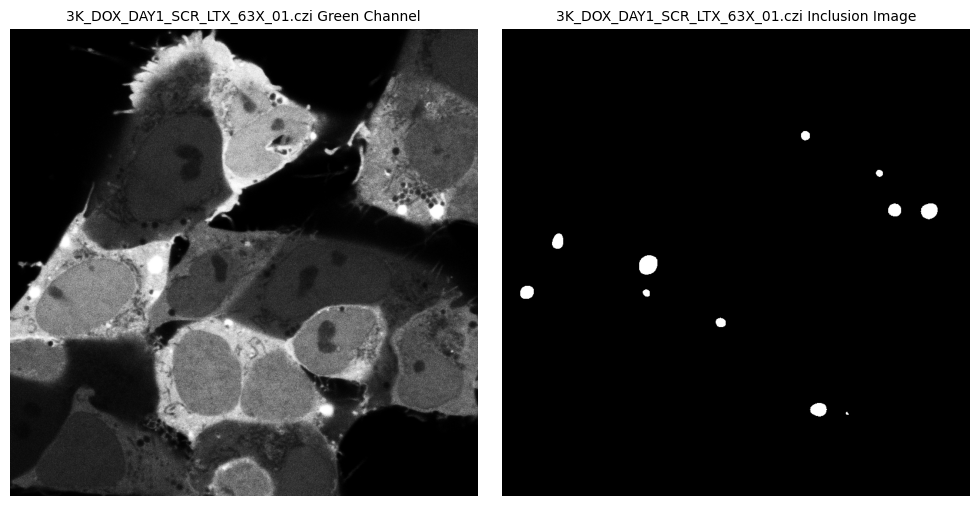

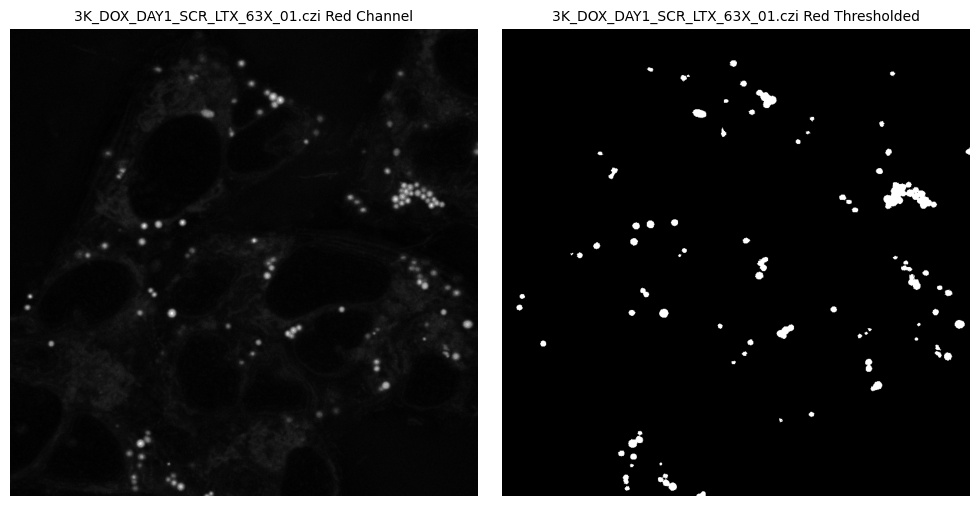

c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\swiss_cheese\swiss_0001.png is a low contrast image
  return func(*args, **kwargs)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\swiss_cheese\swiss_0005.png is a low contrast image
  return func(*args, **kwargs)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\solid\solid_0005.png is a low contrast image
  return func(*args, **kwargs)


Saved images\swiss_cheese\swiss_0001.png shape (128, 128)
Saved images\swiss_cheese\swiss_0002.png shape (128, 128)
Saved images\swiss_cheese\swiss_0003.png shape (128, 128)
Saved images\swiss_cheese\swiss_0004.png shape (128, 128)
Saved images\swiss_cheese\swiss_0005.png shape (128, 128)
Saved images\swiss_cheese\swiss_0006.png shape (128, 128)
Saved images\solid\solid_0001.png shape (128, 128)
Saved images\solid\solid_0002.png shape (128, 128)
Saved images\solid\solid_0003.png shape (128, 128)
Saved images\solid\solid_0004.png shape (128, 128)
Saved images\solid\solid_0005.png shape (128, 128)


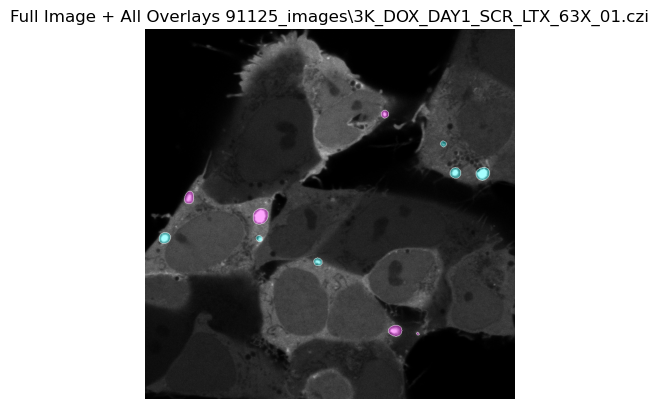

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


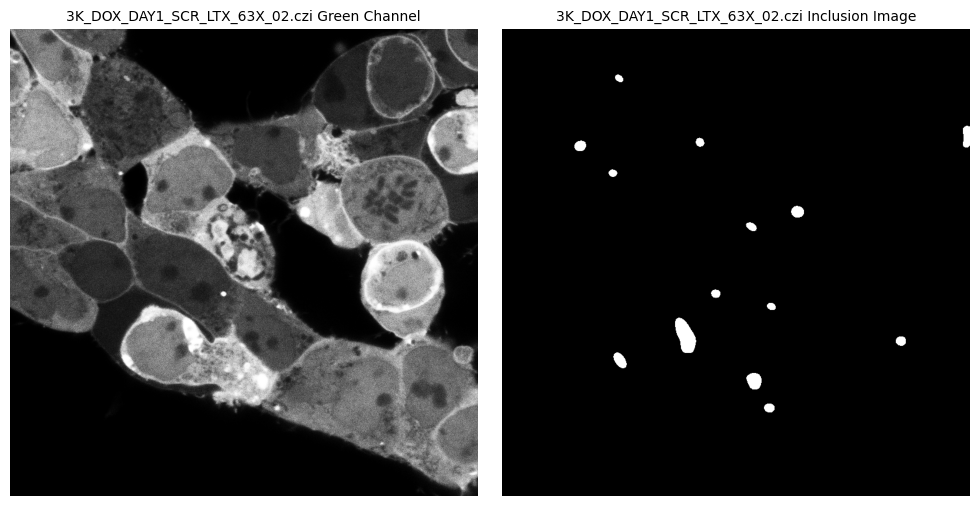

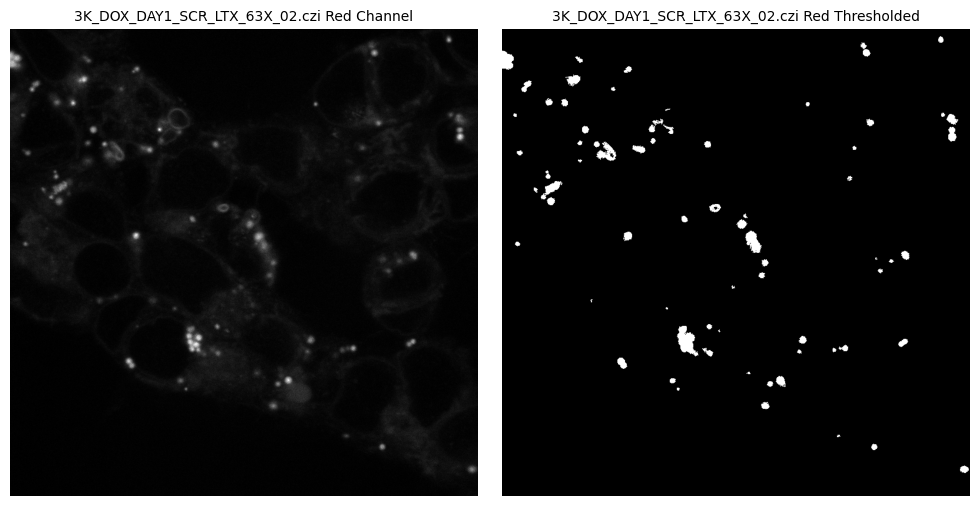

Saved images\swiss_cheese\swiss_0001.png shape (128, 128)
Saved images\swiss_cheese\swiss_0002.png shape (128, 128)
Saved images\swiss_cheese\swiss_0003.png shape (128, 128)
Saved images\swiss_cheese\swiss_0004.png shape (128, 128)
Saved images\swiss_cheese\swiss_0005.png shape (128, 128)
Saved images\solid\solid_0001.png shape (128, 128)
Saved images\solid\solid_0002.png shape (128, 128)
Saved images\solid\solid_0003.png shape (128, 128)
Saved images\solid\solid_0004.png shape (128, 128)
Saved images\solid\solid_0005.png shape (128, 128)
Saved images\solid\solid_0006.png shape (128, 128)
Saved images\solid\solid_0007.png shape (128, 128)
Saved images\solid\solid_0008.png shape (128, 128)
Saved images\solid\solid_0009.png shape (128, 128)


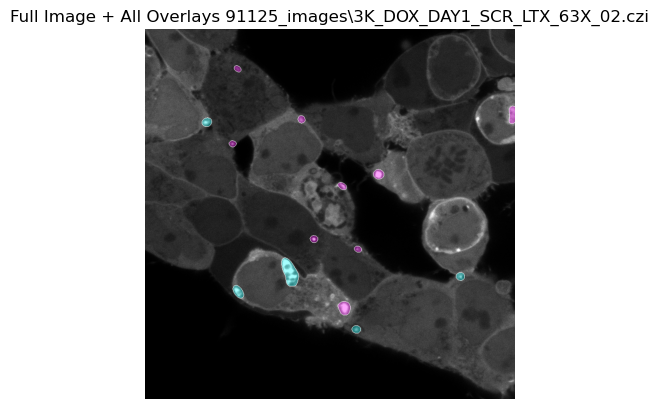

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


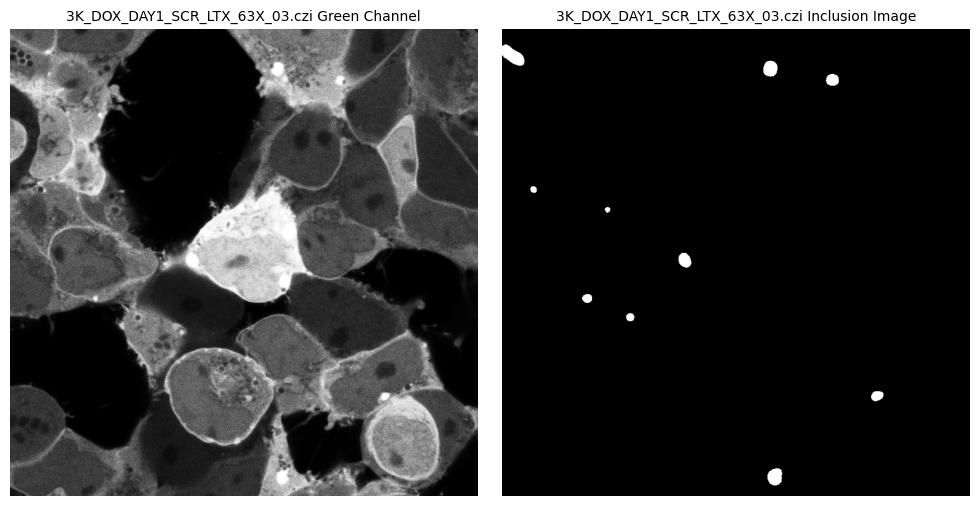

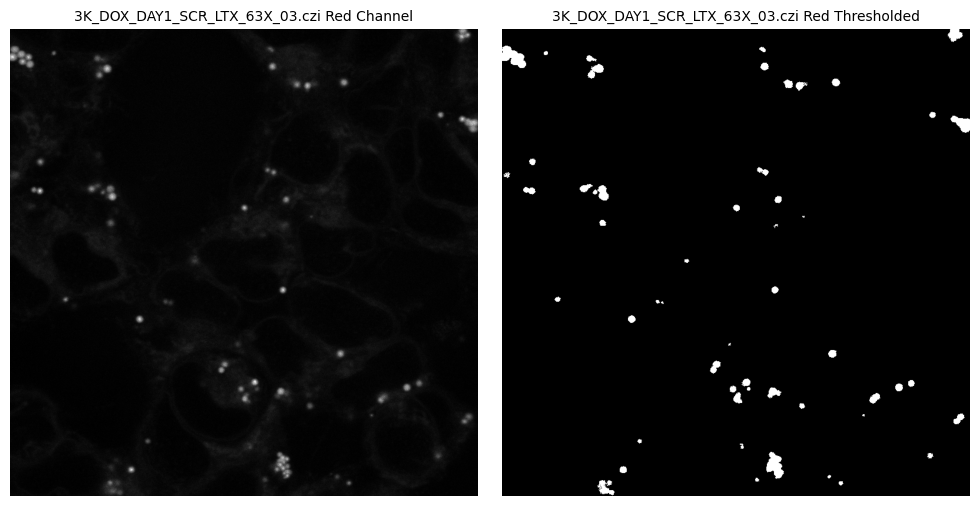

Saved images\swiss_cheese\swiss_0001.png shape (128, 128)
Saved images\swiss_cheese\swiss_0002.png shape (128, 128)
Saved images\swiss_cheese\swiss_0003.png shape (128, 128)
Saved images\swiss_cheese\swiss_0004.png shape (128, 128)
Saved images\swiss_cheese\swiss_0005.png shape (128, 128)
Saved images\swiss_cheese\swiss_0006.png shape (128, 128)
Saved images\swiss_cheese\swiss_0007.png shape (128, 128)
Saved images\swiss_cheese\swiss_0008.png shape (128, 128)
Saved images\solid\solid_0001.png shape (128, 128)
Saved images\solid\solid_0002.png shape (128, 128)


c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\swiss_cheese\swiss_0004.png is a low contrast image
  return func(*args, **kwargs)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\solid\solid_0001.png is a low contrast image
  return func(*args, **kwargs)


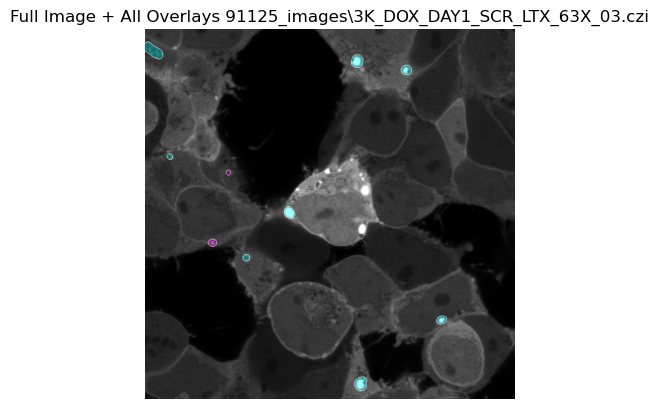

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


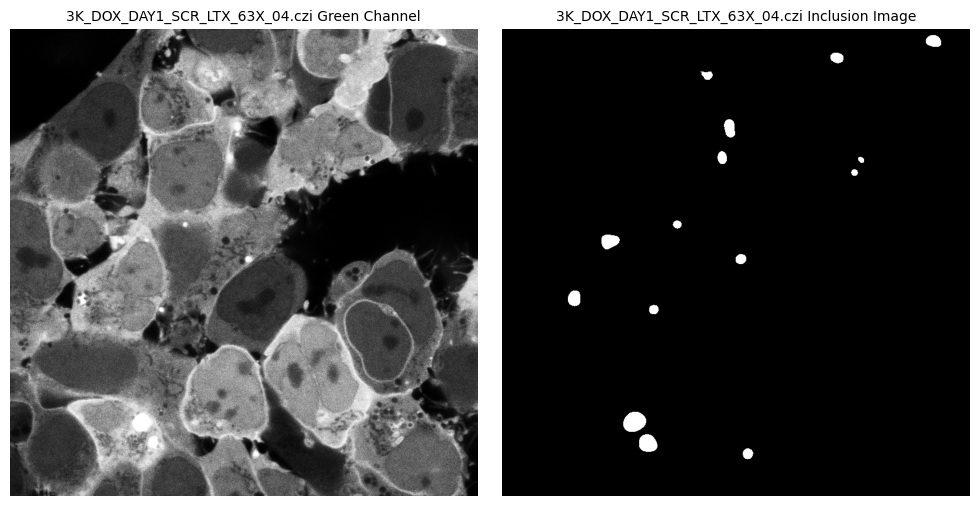

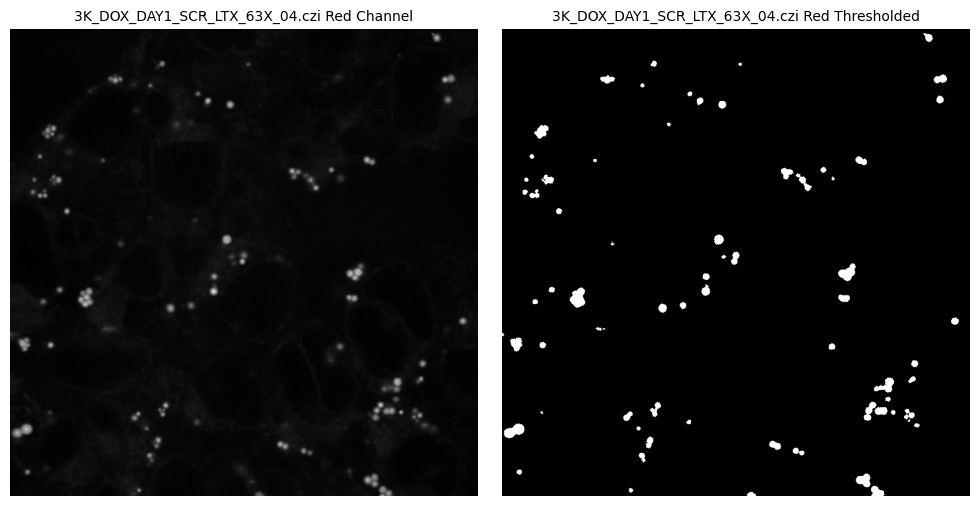

Saved images\swiss_cheese\swiss_0001.png shape (128, 128)
Saved images\swiss_cheese\swiss_0002.png shape (128, 128)
Saved images\swiss_cheese\swiss_0003.png shape (128, 128)
Saved images\swiss_cheese\swiss_0004.png shape (128, 128)
Saved images\swiss_cheese\swiss_0005.png shape (128, 128)
Saved images\swiss_cheese\swiss_0006.png shape (128, 128)
Saved images\solid\solid_0001.png shape (128, 128)
Saved images\solid\solid_0002.png shape (128, 128)
Saved images\solid\solid_0003.png shape (128, 128)
Saved images\solid\solid_0004.png shape (128, 128)
Saved images\solid\solid_0005.png shape (128, 128)
Saved images\solid\solid_0006.png shape (128, 128)
Saved images\solid\solid_0007.png shape (128, 128)
Saved images\solid\solid_0008.png shape (128, 128)
Saved images\solid\solid_0009.png shape (128, 128)


c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\swiss_cheese\swiss_0002.png is a low contrast image
  return func(*args, **kwargs)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\solid\solid_0005.png is a low contrast image
  return func(*args, **kwargs)


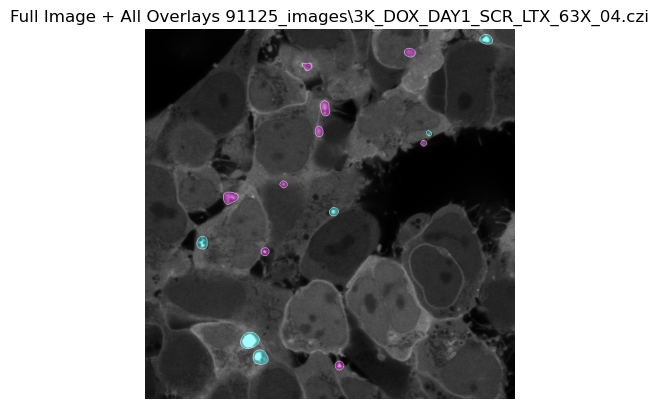

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


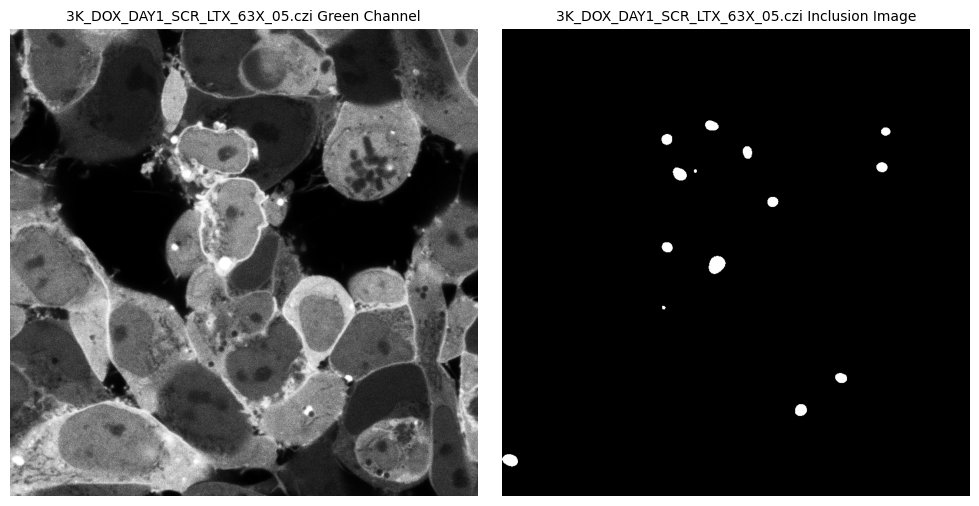

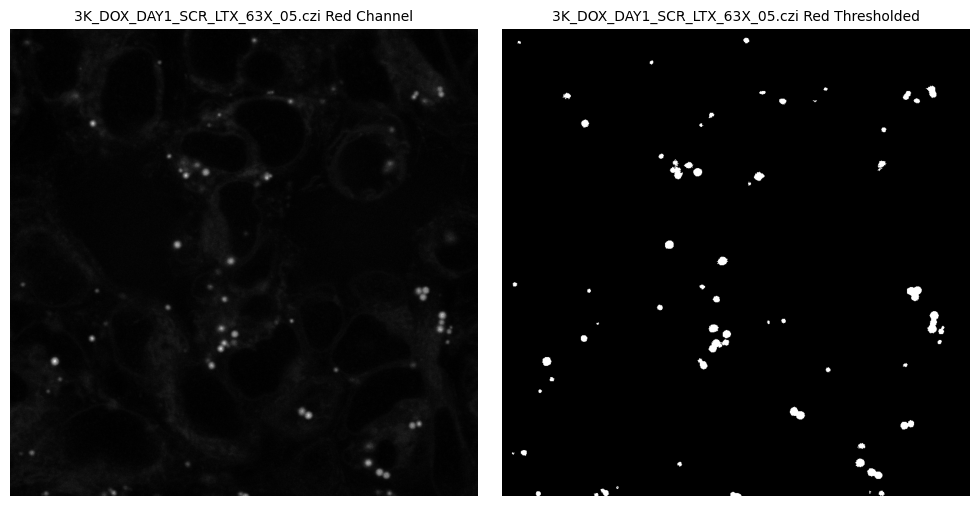

Saved images\swiss_cheese\swiss_0001.png shape (128, 128)
Saved images\swiss_cheese\swiss_0002.png shape (128, 128)
Saved images\swiss_cheese\swiss_0003.png shape (128, 128)
Saved images\swiss_cheese\swiss_0004.png shape (128, 128)
Saved images\swiss_cheese\swiss_0005.png shape (128, 128)
Saved images\swiss_cheese\swiss_0006.png shape (128, 128)
Saved images\solid\solid_0001.png shape (128, 128)
Saved images\solid\solid_0002.png shape (128, 128)
Saved images\solid\solid_0003.png shape (128, 128)
Saved images\solid\solid_0004.png shape (128, 128)
Saved images\solid\solid_0005.png shape (128, 128)
Saved images\solid\solid_0006.png shape (128, 128)
Saved images\solid\solid_0007.png shape (128, 128)
Saved images\solid\solid_0008.png shape (128, 128)


c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\solid\solid_0004.png is a low contrast image
  return func(*args, **kwargs)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\solid\solid_0006.png is a low contrast image
  return func(*args, **kwargs)


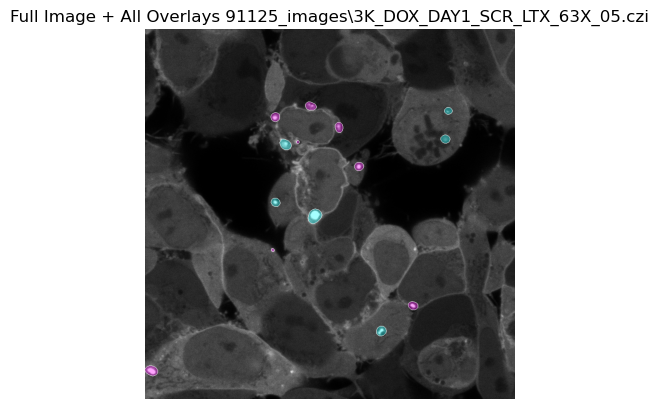

Starting analysis...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


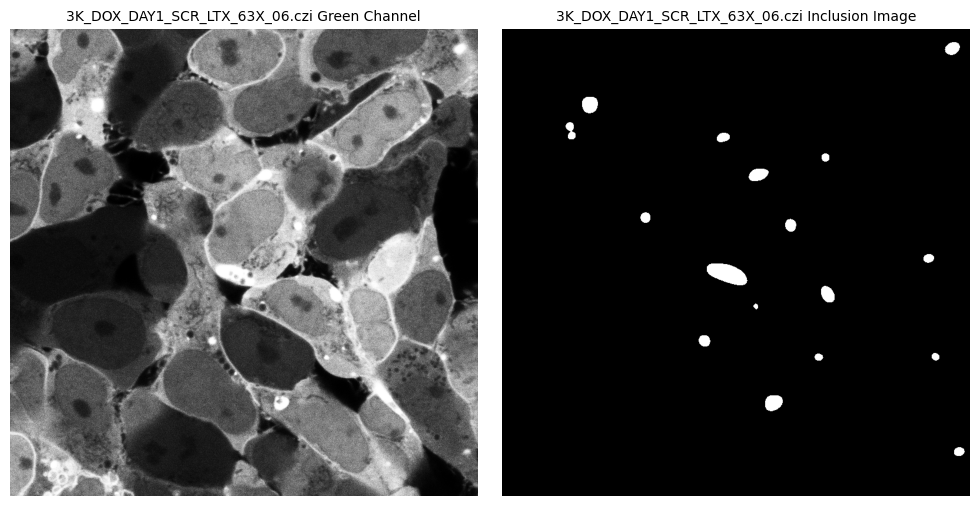

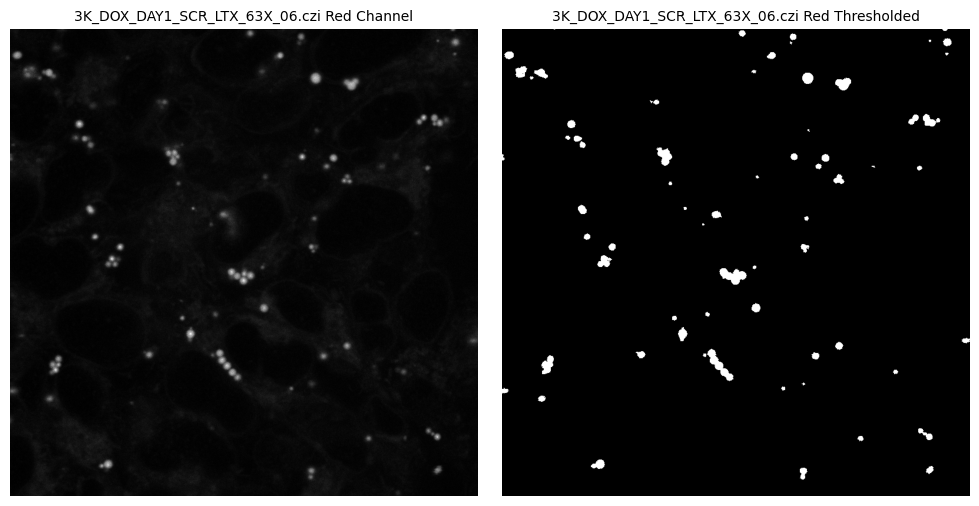

Saved images\swiss_cheese\swiss_0001.png shape (128, 128)
Saved images\swiss_cheese\swiss_0002.png shape (128, 128)
Saved images\swiss_cheese\swiss_0003.png shape (128, 128)
Saved images\swiss_cheese\swiss_0004.png shape (128, 128)
Saved images\swiss_cheese\swiss_0005.png shape (128, 128)
Saved images\solid\solid_0001.png shape (128, 128)
Saved images\solid\solid_0002.png shape (128, 128)
Saved images\solid\solid_0003.png shape (128, 128)
Saved images\solid\solid_0004.png shape (128, 128)
Saved images\solid\solid_0005.png shape (128, 128)
Saved images\solid\solid_0006.png shape (128, 128)
Saved images\solid\solid_0007.png shape (128, 128)
Saved images\solid\solid_0008.png shape (128, 128)
Saved images\solid\solid_0009.png shape (128, 128)
Saved images\solid\solid_0010.png shape (128, 128)
Saved images\solid\solid_0011.png shape (128, 128)
Saved images\solid\solid_0012.png shape (128, 128)


c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\swiss_cheese\swiss_0004.png is a low contrast image
  return func(*args, **kwargs)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: images\solid\solid_0010.png is a low contrast image
  return func(*args, **kwargs)


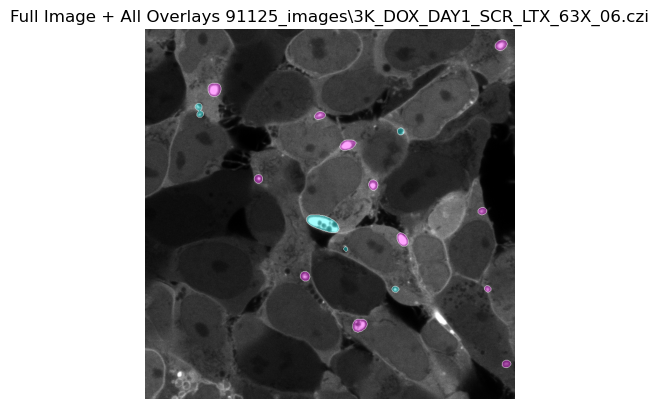

Starting analysis...


Compute Image Embeddings 2D:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()
    df_cell_summary_list = []
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=MODEL_TYPE,
        checkpoint=CHECKPOINT,
        device=DEVICE,
        is_tiled=False,
    )
    total_swiss_cheese = 0
    total_solid = 0

    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 
    
        green,red = extract_channels(image_squeezed)

        number_swiss_cheese, number_solid = analysis(green, red, path, predictor, segmenter)
        total_swiss_cheese += number_swiss_cheese
        total_solid += number_solid

        #df_cell_summary_list.append(df_cell_summary)


    print(f"Total Swiss Cheese Inclusions: {total_swiss_cheese}"
          f"\nTotal Solid Inclusions: {total_solid}")

if __name__ == "__main__":
    image_folder = '91125_images'
    main(image_folder)